# <center> Testing computation of gradient using JAX

In [1]:
import sys
sys.path.append('..')
# reload local packages automatically
%load_ext autoreload
%autoreload 2

In [2]:
# import general moudles
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax
import scipy
import jax.scipy as jscipy
import matplotlib.pyplot as plt

from jax import config
config.update("jax_enable_x64", True)


# Idea:
1. We want to minimize the function: $$ ||  e^{\tau \hat{L}} - Y_{even}^{(1)} Y_{odd}^{(2)} Y_{even}^{(3)} ||^2 $$
with $$ Y = X X^\dagger $$, for some $X \in \mathcal{C}^{m \times m}$

2. Assume all the layers are different
3. Implement the contration of the diagram. In words: 3 layers, 1st and 3rd layer are acting on the even sites, 2nd layer acting on the odd sites. We assume for $N = 6$ sites. 
4. At the moment don't assume a specific distribution, but rather just 3 layers: $Y_{i}$, $(i \in {even, odd})$
5. Once the contraction is made, I can use JAX to find the gradient wrt to each of the $Y$.
6. Use gradient descent to update maybe?. If use GDS, we can use the troterization as first step for guess.


In [6]:
# Step 1: create the cost function
from opentn.transformations import op2fullspace, dissipative2liouvillian_full
from opentn.states.qubits import get_ladder_operator

lowering = get_ladder_operator()
raising = get_ladder_operator(adjoint=True)
gamma = 1e-2 # lindbladian parameter

N = 6
d = 2

I = np.eye(d, dtype=complex)
NN = 2
# Create nearest neighbour lindbladian operator
Lnn = np.sqrt(gamma)*(op2fullspace(raising, i=0, N=NN) + op2fullspace(raising, i=1, N=NN))@(op2fullspace(lowering, i=0, N=NN) - op2fullspace(lowering, i=1, N=NN))/4
# vectorize each of the terms and add them together
Lvec = np.zeros(shape=(d**(2*N), d**(2*N)), dtype=complex)
for i in range(0, N-1):
    Lvec += dissipative2liouvillian_full(L=Lnn, i=i, N=N, num_sites=2)
effective_qubits = np.log2(Lvec.shape[0])
print(f'Effective number of qubits {effective_qubits}')

Effective number of qubits 12.0


In [18]:
Lnn.shape

(4, 4)

In [7]:
# Exponentiatate to get time evolving liouvillian operator
t = 1
exp_Lvec = jscipy.linalg.expm(Lvec*t) # this is the exp(\hat{L}) that we should apply to the vectorization of the initial density matrix.

In [ ]:
from opentn.transformations import lindbladian2super
super = lindbladian2super(Li=[Lnn], dim=Lnn.shape[0])
super.shape[0] == 2**4 == 16

In [ ]:
from opentn.transformations import vectorize

M = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
M_vec = vectorize(M)
M_vec.shape
M_vec_spread = np.reshape(M_vec, newshape=(2,2,2,2))
M_spread = M.reshape((2,2,2,2))
print(M_vec_spread[0,0,0,0])

In [ ]:
M_spread == M_vec_spread

# <center> TIME TO ROCK:

In [ ]:
# Exponential that we are comparing to: exp_Lvec

# we can define the cost function
@jit
def cost(X1, X2, X3):
   "cost function for 'troterization' of exponential"
   # check the dimensions of all the x_i are compatible with full exponential
   Xs = [X1,X2,X3]
   for X in Xs:
      assert X.shape == exp_Lvec.shape, f'Shape of tensors should be: {exp_Lvec.shape}'
   
   eff_sites = int(np.log2(exp_Lvec.shape[0]))
   
   Ys = []
   # I think the most effective way of doing thins is just making all of them into matrices no?
   for X in Xs:
      # convert each of the X into a matrix
      if X.ndim > 2:
         X = jnp.reshape(a=X, newshape=[int(np.sqrt(X.size))]*2)
      Y = jnp.dot(X, X.T.conj())
      Ys.append(Y)
      # y = jnp.tensordot(x, x.conj(), axes=(list(range(eff_sites)),list(range(eff_sites))))
      # Ys.append(y.reshape((exp_Lvec.shape[0], exp_Lvec.shape[1])))

   Y_total = Ys[0]
   for Y in Ys[1:]:
      Y_total = jnp.dot(Y, Y_total)
      
   return jnp.linalg.norm(vectorize(exp_Lvec) - vectorize(Y_total))

In [ ]:
derivative_fn = grad(cost)

In [8]:
# In theory the first guesses could be the X1, X2, X3 comning from the cholesky decomposition of the e^odd and e^even

# Y1 and Y3:
Lvec_odd = np.zeros(shape=(d**(2*N), d**(2*N)), dtype=complex)
for i in range(0, N, 2):
    Lvec_odd += dissipative2liouvillian_full(L=Lnn, i=i, N=N, num_sites=2)

print(f'Effective number of qubits { np.log2(Lvec_odd.shape[0])}')
# Y2
Lvec_even = np.zeros(shape=(d**(2*N), d**(2*N)), dtype=complex)
for i in range(1, N-1, 2):
    Lvec_even += dissipative2liouvillian_full(L=Lnn, i=i, N=N, num_sites=2)

print(f'Effective number of qubits {np.log2(Lvec_even.shape[0])}')


Effective number of qubits 12.0
Effective number of qubits 12.0


In [9]:
np.allclose(Lvec, Lvec_even  + Lvec_odd)
# they do add up to Lvec

True

In [ ]:
#  NOTE: numpy version is 40 seconds slower than jax. Time: 1m 27.7s
# exp_Lvec_odd = expm(Lvec_odd*t/2) 
# exp_Lvec_even = expm(Lvec_even*t) 

In [10]:
# converting to exponential
# this is the exp(\hat{L}) that we should apply to the vectorization of the initial density matrix.
exp_Lvec_odd = jscipy.linalg.expm(Lvec_odd*t/2) #changing to jax again
exp_Lvec_even = jscipy.linalg.expm(Lvec_even*t) #changing to jax again

In [ ]:
X1 = jnp.linalg.cholesky(exp_Lvec_odd)

In [ ]:
jnp.linalg.norm(exp_Lvec_odd - exp_Lvec_odd.conj().T)

In [ ]:
jnp.linalg.norm(exp_Lvec_even - exp_Lvec_even.conj().T)

In [ ]:
Y1 = jnp.dot(X1, X1.T.conj())

In [ ]:
jnp.allclose(exp_Lvec_odd, Y1)

In [ ]:
exp_Lvec_odd - Y1

In [ ]:
X2 = jnp.linalg.cholesky(exp_Lvec_even)

In [ ]:
cost_jit = jit(cost)

In [ ]:
cost_jit(X1=X1, X2=X2, X3=X1) # NOTE: old value: 0.15904978 (when using t instead of t/2 in odd layer)

In [ ]:
grad_x1, grad_x2, grad_x3 = grad(cost_jit, (0,1,2))(X1, X2, X1)

In [ ]:
jnp.linalg.norm(grad_x3)

In [ ]:
cost_eval, grad_x = jax.value_and_grad(cost_jit, (0,1,2))(X1, X2, X1)

In [ ]:
jnp.allclose(grad[2],grad_x3)

In [ ]:
# Now we can update the X matrices and see if these reach a better cost function
# NOTE: I wrongly use t=1 instead of 1/2 for the exponential of X1 (and thus X3). We see if we can do better then
# NOTE: I fix the error
rate = 0.01
X1_new = X1 - rate*grad_x[0]
X2_new = X2 - rate*grad_x[1]
X3_new = X1 - rate*grad_x[2]

In [ ]:
# now lets do another optimization step!
cost_eval_2, grad_x_2 = jax.value_and_grad(cost_jit, (0,1,2))(X1_new, X2_new, X3_new)

In [ ]:
X1_new2 = X1_new - rate*grad_x_2[0]
X2_new2 = X2_new - rate*grad_x_2[1]
X3_new2 = X3_new - rate*grad_x_2[2]
cost_jit(X1=X1_new2, X2=X2_new2, X3=X3_new2)

In [ ]:
jnp.linalg.norm(grad_x_2[1])

In [ ]:
jnp.linalg.norm(grad_x[1])

In [ ]:
# third step just to save some time
params_len = 3
cost_eval_3, grad_x_3 = jax.value_and_grad(cost_jit, list(range(params_len)))(*[X1_new2, X2_new2, X3_new2])

In [ ]:
X1_new3 = X1_new2 - rate*grad_x_3[0]
X2_new3 = X2_new2 - rate*grad_x_3[1]
X3_new3 = X3_new2 - rate*grad_x_3[2]
cost_eval_4 = cost_jit(X1=X1_new3, X2=X2_new3, X3=X3_new3)

In [ ]:
cost_list, xi = gds(fn=cost_jit, x0=[X1_new3, X2_new3, X3_new3], iter=7)

In [ ]:
cost_eval_last = cost_jit(*xi)

In [ ]:

fig = plt.figure(dpi=300)
plt.plot(range(11), [cost_eval, cost_eval_2, cost_eval_3] + cost_list[:] + [cost_eval_last], '--x')

In [5]:
# Now I want to try if having a different cost function changes anything?
def frobenius_norm(A,B):
    return jnp.linalg.norm(A-B, ord='fro')

@jit
def contractions(Xs):
    
    Ys = []
    for X in Xs:
        # convert each of the X into a matrix
        if X.ndim > 2:
            X = jnp.reshape(a=X, newshape=[int(np.sqrt(X.size))]*2)
        Y = jnp.dot(X, X.T.conj())
        Ys.append(Y)
    # Here i should reshuffle the legs to go: choi-> superoperator
    Y_total = Ys[0]
    for Y in Ys[1:]:
        Y_total = jnp.dot(Y, Y_total)
    return Y_total

def cost_fn(X1, X2, X3, loss_fn):
    "cost function for 'troterization' of exponential. The choi matrix is the one that should be PSD"
    # check the dimensions of all the x_i are compatible with full exponential
    Xs = [X1,X2,X3]
    for X in Xs:
        assert X.shape == exp_Lvec.shape, f'Shape of tensors should be: {exp_Lvec.shape}'
    
    Y_total = contractions(Xs)
    assert exp_Lvec.ndim == Y_total.ndim == 2, 'Y_total should be a matrix'
    return jit(loss_fn)(exp_Lvec, Y_total)

In [ ]:
cost_fn(X1, X2, X1, loss_fn=frobenius_norm)

In [ ]:
cost_list_fro, xi_fro = gds(fn=cost_fn, x0=[X1, X2, X1], iter=10, loss_fn=frobenius_norm)

In [ ]:
cost_list_2norm = [cost_eval, cost_eval_2, cost_eval_3] + cost_list[:] + [cost_eval_last]

fig = plt.figure(dpi=300)
plt.plot(range(11), [c/cost_list_fro[0] for c in cost_list_fro], '--x', label='cost fn: frobenius_norm', markersize=3.5, linewidth=1.0)
plt.plot(range(11), [c/cost_list_2norm[0] for c in cost_list_2norm], '--x', label='cost fn: 2-norm', markersize=3.5, linewidth=1.0)
plt.ylabel(r'$Cost_n/Cost_0$')
plt.xlabel('iteration')
plt.legend()
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)

print(f'frobenius norm: \n initial: {cost_list_fro[0]} \n final: {cost_list_fro[-1]}')
print(f'2-norm: \n initial: {cost_list_2norm[0]} \n final: {cost_list_2norm[-1]}')

In [ ]:
fig = plt.figure(dpi=300)
plt.plot(range(11), [v-f for f,v in zip(cost_list_fro,cost_list_2norm)], '--x', label='(2norm) - (frobenius)', markersize=3.5, linewidth=1.0)
plt.legend()
print(f'difference between functions: {cost_list_2norm[-1] - cost_list_fro[-1]}')

# Thoughts

1. If I want to use the method with kraus operators, I have to be careful. Becuase it still possible to generate the kraus operators for these systems of $N=6$ but they would be big and acting on many bond dimensions at at time. Besides, I would have to decide how to distribute the kraus dimension among the different sites.

2. To achieve this, I can perform a second optimization of each layer s.t: 
$$Y_i = \bigotimes_n Z^{[n,n+1]}$$
With Z, some operators acting only on neighbouring sites.

3. The code is a bit messy, I think I should separate the contraction with the actual cost function that I am using. Maybe just changing the naming of the functions?

4. **NOTE**: no boundary conditions are being implemented now

5. I am waiting the results to see if changing the cost function changes anything: it barely changes something to be honest. UPDATE: the optimization does help, but as we can see, the cost (norm difference) is already quite low so the change is also not so significant.

6. Read more on the error mitigation paper and see if I can get any useful input from it. 
    > Ideas: 
    > - they transform the problem to a "linear problem"
    > - where do they use the rayleigh quotient?
    > - what optimization method do they use? GDS also?
7. **NOTE**: don't forget what Ayse did. I have learned a bit about matrix manifolds, should look into that direction as well.

# TODO:
1. <s>Improve naming convention for `cost_fn` and `loss_fn`  </s>.
2. <s>Have a code implementation where I can use JIT even when passing a parameter like `loss_fn`. Maybe solved by (1)? </s>
3. Implement another optimization step to distribute $Y_i$ onto terms I can exress as kraus operators on NN.
4. Test if they make a difference in the accuracy of the time evolution
5. Implement boundary conditions. How?

# Optimizing to get NN terms:

In [ ]:

def cost_xi(Z1,Z2,Z3, *, Xi, loss_fn):
    """
    cost function for a split of a layer Y_i (X_i) onto 3 blocks tensored
    
    Here we are using only half of the layer: X_i such that Y_i = X_i @ X_i.adj().T
    and we want to get Z1, Z2, Z3 such that: X_i = Z1 (x) Z2 (x) Z3
    and then: Y_i = Z1 @ Z_i.adj().T  (x) Z2 @ Z_i.adj().T (x) Z3 @ Z_i.adj().T
    """
    Z_total = jnp.kron(Z1, jnp.kron(Z2, Z3))
    return loss_fn(Z_total, Xi)

In [ ]:
X1.shape
test = jnp.ones((2**4,2**4))
cost_xi(*[test]*3, Xi=X1, loss_fn=frobenius_norm)

In [ ]:
# if the legs are actually grouped by site (4 legs per site), then I would have to reorder the exp legs
# but it seems weird if that is the case when using vectorize.
# i think i can check if its correct from how i vectorize the lindbladian that gives rise to the exponential?

# <center> After 06.06 Meeting

# Testing the superoperator <-> choi conversion

In [ ]:
# lets use the e^odd to check this
from opentn.transformations import super2choi, choi2super
choi = super2choi(exp_Lvec_odd, dim=2**N)

np.allclose(choi2super(choi, dim=2**N), exp_Lvec_odd)

# Need to check if the $e^{\mathcal{L}_o}$ is correctly produced

In [ ]:
# This is how it is produced above
# exp_Lvec_odd =jscipy.linalg.expm(Lvec_odd*t/2) 
# exp_Lvec_even = jscipy.linalg.expm(Lvec_even*t) 
# These act on [0,1] [2,3] [4,5]
# NOW, compare when tensor product the individual 2 site terms
super = lindbladian2super(Li=[Lnn], dim=Lnn.shape[0])
super_exp = scipy.linalg.expm(super*t/2)
print(super_exp.shape)
super_exp_full = jnp.kron(super_exp, jnp.kron(super_exp, super_exp))
print(super_exp_full.shape)
# now that we the full thing, check if they are the same
print(jnp.allclose(super_exp_full, exp_Lvec_odd))
# We see its false, as expected. So we have to rearange the legs!
# first reshape it to have 12 legs on each side with local dimension 2 each. We use 4 because we have both sides of the matrix
super_exp_full = jnp.reshape(super_exp_full, newshape=[2]*4*N)
# now reshuffel the legs.
# NOTE: METHOD 1
new_order = [0,1,4,5,8,9,2,3,6,7,10,11]
super_exp_full = jnp.transpose(super_exp_full, axes=new_order + list(jnp.array(new_order) + 2*N))
# NOTE: METHOD 2
# source_idx = [2,3,6,7]
# destination_idx = [6,7,8,9]
# super_exp_full = jnp.moveaxis(super_exp_full, source=source_idx + list(jnp.array(source_idx) + 2*N), destination=destination_idx + list(np.array(destination_idx) + 2*N))
# go back to original shape
super_exp_full = jnp.reshape(super_exp_full, newshape=exp_Lvec_odd.shape)
print(jnp.allclose(super_exp_full, exp_Lvec_odd))

In [357]:

n = 4





[4, 5]


[2, 3]

# Now redoing the cost function

In [12]:
# Now I should re do the simulations!
# redo the cost function. The one that is positive semidefinite is the choi matrix.
# so Y = Choi matrix = X X+
# the one that acts on the vectorization of the density matrix (LPDO) is the superoperator (?)
# or rather: we are splitting: e^L = e^1 e^2 e^3 so these are the ones that should be multiplied at the end in the cost function

def frobenius_norm(A,B):
    return jnp.linalg.norm(A-B, ord='fro')

@jit
def contractions(Xs):
    "Xs are assumed to be the square roots of the PSD matrices (Choi)"
    Ys = []
    for X in Xs:
        # convert each of the X into a matrix
        if X.ndim > 2:
            X = jnp.reshape(a=X, newshape=[int(np.sqrt(X.size))]*2)
        Y = jnp.dot(X, X.T.conj())
        Ys.append(Y)
    # convert to superoperators
    Ys_super = [choi2super(choi=Y) for Y in Ys]
    Y_total = Ys_super[0]
    for Y in Ys_super[1:]:
        Y_total = jnp.dot(Y, Y_total)
    return Y_total

def cost_fn(X1, X2, X3, loss_fn):
    "cost function for 'troterization' of exponential. The choi matrix is the one that should be PSD"
    # NOTE: we are going to accept the Xi that correspond to the choi matrix
    # --- choi matrices ---
    Xs = [X1,X2,X3]
    # --- superoperators ---
    Y_total = contractions(Xs)
    
    assert exp_Lvec.ndim == Y_total.ndim == 2, 'Y_total should be a matrix'
    return jit(loss_fn)(exp_Lvec, Y_total)

# The problem is now I have to deal with the small eigenvalues of the choi matrix resulting from the exp of superoperator

In [ ]:
# just to check something, see what are the eigenvalues of the individual superop for odd sites (NN)
C_NN = super2choi(super_exp)
print(jnp.allclose(C_NN.conj().T ,C_NN)) # HERMITIAN: PASS
eigvals_NN, eigvecs_NN = np.linalg.eigh(C_NN)
# print(eigvals_NN)
for eig in eigvals_NN:
    if abs(eig) > 1e-9:
        print(eig)

In [ ]:
C = super2choi(super=exp_Lvec_odd, dim=2**N)
# check if its hermitian
print(jnp.allclose(C.conj().T ,C)) # PASS
# check the eigenvalues
eigvals, eigvecs = np.linalg.eigh(C)
print(eigvals)
# before: -1.4772072e-05 -1.0541916e-05 -8.1017006e-06 ...  1.9974880e-02
# 1.9975079e-02  6.3940044e+01]

In [ ]:
print(len(eigvals))
print(np.max(eigvals)) # stays the same
print(np.min(eigvals)) #min from before: DeviceArray(-1.4772072e-05, dtype=float32)

In [ ]:
print(np.max(eigvals)/np.min(eigvals))

In [ ]:
tol = 1e-8
negative = 0
outside_tol = 0
for eig in eigvals:
    if (eig)<0:
        negative += 1
    if abs(eig) < tol:
        outside_tol += 1
    else:
        print('eig: ',eig)
print(negative)
print(outside_tol)

In [ ]:
positive_eigvals = jnp.array([eig if abs(eig)>tol else 0 for eig in eigvals])
C_pos = eigvecs@jnp.diag(positive_eigvals)@eigvecs.conj().T

In [ ]:
jnp.allclose(C, C_pos)

In [ ]:
# method 1 for making the new X:
eigvecs_pos = np.empty_like(eigvecs)
for i, eig in enumerate(eigvals):
    if abs(eig) < tol:
        eig = 0
    eigvecs_pos[:,i] = eigvecs[:,i]*jnp.sqrt(eig)

# jnp.allclose(C, eigvecs_pos@eigvecs_pos.conj().T): True

In [ ]:
# method 2:
D_sqrt = np.diag([jnp.sqrt(eig) if abs(eig)>=tol else 0 for eig in eigvals])
eigvecs_pos2 = jnp.tensordot(eigvecs, D_sqrt, axes=(-1,0))
# jnp.allclose(C, eigvecs_pos2@eigvecs_pos2.conj().T): True

### DONE! now for $X_2$

In [ ]:
negative = 0
outside_tol = 0
for eig in positive_eigvals:
    if (eig)<0:
        negative += 1
    if abs(eig) < tol:
        outside_tol += 1
    else:
        print('eig: ',eig)
print(negative)
print(outside_tol)

`LinAlgError: 196-th leading minor of the array is not positive definite`
the error happens even when all eigvals are non negative, because cholesky checks `>` not `>=`. Zeros on diag would also affect, same as small numbers

In [ ]:
# scipy.linalg.cholesky(C_pos) # the scipy version and the numpy version give error: not positive semidefinite matrix
# np.array([[1,0],[0,1e-18]])

In [ ]:
X1 = eigvecs_pos
C2 = super2choi(super=exp_Lvec_even, dim=2**N)
# check the eigenvalues
eigvals2, eigvecs2 = np.linalg.eigh(C2)
X2 = np.empty_like(eigvecs2)
for i, eig in enumerate(eigvals2):
    if abs(eig) < tol:
        eig = 0
    X2[:,i] = eigvecs2[:,i]*jnp.sqrt(eig)

In [ ]:
jnp.allclose(C2, X2@X2.conj().T)

In [ ]:
negative = 0
outside_tol = 0
for eig in eigvals2:
    if (eig)<0:
        negative += 1
    if abs(eig) < tol:
        outside_tol += 1
    else:
        print('eig: ',eig)
print(negative)
print(outside_tol)

In [ ]:
# doing the multiplication 'manually' to see wtf is wrong
exp_approx = exp_Lvec_odd@exp_Lvec_even@exp_Lvec_odd
# evaluating the frobenius norm cost function
print(frobenius_norm(exp_Lvec, exp_approx)) #even doing jit(frobenius_norm) gives the same

In [ ]:
# the only thing left is doing the contraction manually:
def contractions_test(Xs):
    "Xs are assumed to be the square roots of the PSD matrices (Choi)"
    Ys = []
    for X in Xs:
        # convert each of the X into a matrix
        if X.ndim > 2:
            X = jnp.reshape(a=X, newshape=[int(np.sqrt(X.size))]*2)
        Y = X@X.T.conj()
        Ys.append(Y)
    # convert to superoperators
    Ys_super = [choi2super(choi=Y) for Y in Ys]
    Y_total = Ys_super[0]
    for Y in Ys_super[1:]:
        Y_total = Y@Y_total
    return Y_total
exp_approx_from_fn_test = contractions_test([X1,X2,X1])

In [ ]:
frobenius_norm(exp_Lvec,exp_approx_from_fn_test) # NOTE: the result does change when we change dot for @, but it actually becomes higher, and slower.

In [ ]:
# now lets to every step 'manually' to see if sth changes
exp_approx_from_fn = contractions([X1, X2, X1])
jnp.allclose(exp_approx_from_fn, exp_approx)

In [ ]:
# since they are the same, then what is different? is it when jitting the function?
frobenius_norm(exp_Lvec,exp_approx_from_fn)

In [ ]:
cost_fn(X1, X2, X1, frobenius_norm)

> In any case: the results vary a bit if we do it directly from exp() or through `contraction` fn. But this is likely to the approximations done when finding the Xs from exp(Li).  Now lets do a manual step of GDS and see what is going on

In [ ]:
cost_eval_test, grad_x_test = jax.value_and_grad(cost_fn, (0,1,2))(X1, X2, X1, loss_fn=frobenius_norm)
# cost_eval_test: 1.4258275e-05

In [ ]:
for grad in grad_x_test:
    print(jnp.linalg.norm(grad))

In [ ]:
Xo = [X1, X2, X1]
Xi = []
rate = 1e-7
for i in range(len(grad_x_test)):
    Xi.append(Xo[i] - rate*grad_x_test[i])
cost_eval_test_i, grad_x_test_i = jax.value_and_grad(cost_fn, (0,1,2))(*Xi, loss_fn=frobenius_norm)
print(cost_eval_test_i)

| rate | cost          |
|------|---------------|
| 1e-2 | 7.193493      |
| 1e-3 | 0.6897543     |
| 1e-4 | 0.068676315   |
| 1e-5 | 0.006851822   |
| 1-6  | 0.00067363406 |
| 1e-7 | 5.7061345e-05 |


In [ ]:
cost_list_fro, xi_fro = gds(fn=cost_fn, x0=[X1, X2, X1], iter=3, loss_fn=frobenius_norm, rate=1e-7)

In [ ]:
cost_list_fro

In [ ]:
cost_list_fro2, xi_fro2 = gds(fn=cost_fn, x0=xi_fro, iter=5, loss_fn=frobenius_norm, rate=1e-7)

In [ ]:
cost_list_fro3, xi_fro3 = gds(fn=cost_fn, x0=xi_fro2, iter=7, loss_fn=frobenius_norm, rate=1e-8)

In [ ]:
cost_list_fro4, xi_fro4 = gds(fn=cost_fn, x0=xi_fro2, iter=7, loss_fn=frobenius_norm, rate=1e-7)

In [ ]:
cost_list_fro5, xi_fro5 = gds(fn=cost_fn, x0=xi_fro4, iter=2, loss_fn=frobenius_norm, rate=5e-7)

> NOTE: I should return also the gradient? (thinking more about it maybe not)  

In [ ]:
fig = plt.figure(dpi=300)
plt.plot(range(18), [c/cost_list_fro[0] for c in cost_list_fro + cost_list_fro2[1:] + cost_list_fro4 + cost_list_fro5], '--x', label='cost fn: frobenius_norm', markersize=3.5, linewidth=1.0)
plt.ylabel(r'$Cost_n/Cost_0$')
plt.xlabel('iteration')
plt.legend()

# Ideas what to change:
- loss fn: cosine similarity
- change to other optimizer: momentum GDS, SGDS, other? (adam, etc.)
- ask for help :(

In [7]:
from opentn.optimization import calculate_norms, update
from opentn.transformations import vectorize

In [13]:
def cosine_similarity(A:np.ndarray,B:np.ndarray):
    # flatten them as this is defined for vectors.
    a = vectorize(A)
    b = vectorize(B)
    # taking the real part as otherwise the grad calculation should guarantee cost_fn to be holomorphic
    return -(a@b.T.conj() / (jnp.linalg.norm(a)*jnp.linalg.norm(b))).real
    # NOTE: changed the function to have the most negative when A = B

In [ ]:
cosine_similarity(exp_Lvec, exp_Lvec) # all with jnp

In [ ]:
cosine_similarity(exp_Lvec, exp_Lvec) # all with jnp:-0.99999315

In [ ]:
frobenius_norm(exp_Lvec, exp_Lvec)

In [ ]:
test_matrices = [exp_approx, exp_approx_from_fn_test, exp_approx_from_fn, exp_Lvec]
for test in test_matrices:
    print(cosine_similarity(exp_Lvec, test)) 
# WHAT IS GOING ON HERE? now the values are higher than one? how can you even distinguish from numerical noise

without jax on process and without jax on cost function:
-1.000000000000195
-1.0000000000001705
-0.9999925
-1.0000000000002003

without jax on process but still jax in cost function:
-0.99999994
-0.9999999
-0.9999924
-0.99999994

with jax scipy and numpy in process and cost function:
-0.99999326
-0.9999925
-0.99999255
-0.99999315

process == how we calculate the superoperator exponential

> NOTE: having np.linalg.norm instead of jnp version in the cost function makes an error happen

In [ ]:
cost_list_cos_np, grads_list_cos_np, params_list_cos_np = gds(fn=cost_fn, x0=[X1, X2, X1], iter=5, loss_fn=cosine_similarity, rate=1e2)

In [ ]:
len(params_list_cos_np)

In [ ]:
data = cost_list_cos_np
l = len(data)
fig = plt.figure(dpi=300)
plt.plot(range(l), [(d) for d in data], '--x', label='cost fn: cosine similarity', markersize=3.5, linewidth=1.0)
plt.axhline(y=-0.99999994, label='ideal value')
plt.ylabel(r'$Cost_n$')#/Cost_0$')
plt.xlabel('iteration')
plt.legend()
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)

In [ ]:
# based on the values we see these are the simulations when jax was used for process and cost fn
cost_list_cos, xi_cos, grads_list_cos = gds(fn=cost_fn, x0=[X1, X2, X1], iter=2, loss_fn=cosine_similarity, rate=1e2)

In [ ]:
cost_list_cos2, xi_cos2, grads_list_cos2 = gds(fn=cost_fn, x0=xi_cos, iter=5, loss_fn=cosine_similarity, rate=1e2)

In [ ]:
for i, grads in enumerate(grads_list_cos2):
    print('iteration:', i)
    calculate_norms(grads)
    print()

In [ ]:
data

In [ ]:
data = cost_list_cos + cost_list_cos2[:-1]
l = len(data)
fig = plt.figure(dpi=300)
plt.plot(range(l), [(d) for d in data], '--x', label='cost fn: cosine similarity', markersize=3.5, linewidth=1.0)
plt.axhline(y=cosine_similarity(exp_Lvec, exp_Lvec), label='ideal value')
plt.ylabel(r'$Cost_n$')#/Cost_0$')
plt.xlabel('iteration')
plt.legend()
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)

In [ ]:
# optional cosine cost value
print(cost_list_cos_np[3])
optimal_params = params_list_cos_np[3]

In [ ]:
# lets see what is the cost function with frobenius norm of the optimal parameters obtained in cosine 
# test_matrices = [exp_approx, exp_approx_from_fn_test, exp_approx_from_fn, exp_Lvec]
for test in test_matrices:
    print(frobenius_norm(exp_Lvec, test)) 

# checking what is the cost function of all the params we found with the other method
for params in params_list_cos_np:
    print(cost_fn(*params, loss_fn=frobenius_norm))

In [ ]:
# now let me try with similar parameters for frobenius again

cost_list_fro_np, xi_fro_np, grads_list_fro_np = gds(fn=cost_fn, x0=[X1, X2, X1], iter=5, loss_fn=frobenius_norm, rate=1e-2)

for rate = 1e2 it did not work, changes are way too big!

In [ ]:
# old xs
calculate_norms([X1, X2])
calculate_norms(xi_cos)
# are they the same?
jnp.allclose(xi_cos[2], X1) # THEY ARE THE SAME! why did it not change?

In [ ]:
calculate_norms([exp_Lvec])

In [ ]:
cost_eval_test, grad_x_test = jax.value_and_grad(cost_fn, (0,1,2))(X1, X2, X1, loss_fn=cosine_similarity)
# cost:0.99999255

In [ ]:
calculate_norms(grad_x_test)

In [ ]:
# lets see what happens for 3 random matrices
# key = jax.random.PRNGKey(0)
size = X1.shape[0] #4096
Xs_rnd = []
for _ in range(3):
    Xs_rnd.append(np.random.normal(size=(size,size)) / np.sqrt(size*size))
calculate_norms(Xs_rnd)

cost_eval_rnd, grad_x_rnd = jax.value_and_grad(cost_fn, (0,1,2))(*Xs_rnd, loss_fn=cosine_similarity)
cost_eval_rnd

In [ ]:
calculate_norms(grad_x_rnd)

In [ ]:
Xs_rnd_upd = update(Xs_rnd, grad_x_rnd, rate=0.1)
calculate_norms(Xs_rnd_upd)

In [ ]:
for i in range(3):
    print(np.allclose(Xs_rnd[i], Xs_rnd_upd[i]))
cost_eval_rnd_upd, grad_x_rnd_upd = jax.value_and_grad(cost_fn, (0,1,2))(*Xs_rnd_updated, loss_fn=cosine_similarity)
cost_eval_rnd_upd

In [ ]:
cost_eval_rnd_upd < cost_eval_rnd

In [ ]:
# try to see what happens with random input for frobenius
cost_eval_fro_rnd, grad_x_fro_rnd = jax.value_and_grad(cost_fn, (0,1,2))(*Xs_rnd, loss_fn=frobenius_norm)
print(cost_eval_fro_rnd)

In [ ]:
for i in range(3):
    print(jnp.max(grad_x_fro_rnd[i]))

In [ ]:
calculate_norms(grad_x_fro_rnd)
Xs_fro_rnd_upd = update(Xs_rnd, grad_x_fro_rnd, rate=1e7)
calculate_norms(Xs_fro_rnd_upd)
cost_eval_fro_rnd2, grad_x_fro_rnd2 = jax.value_and_grad(cost_fn, (0,1,2))(*Xs_fro_rnd_upd, loss_fn=frobenius_norm)
print(cost_eval_fro_rnd2)

In [ ]:
for i in range(3):
    print(np.allclose(Xs_rnd[i], Xs_fro_rnd_upd[i]))
for i in range(3):
    print(np.max(Xs_rnd[i]))
    print(np.max(Xs_fro_rnd_upd[i]))

In [ ]:
print(cost_eval_fro_rnd2)
print(cost_eval_fro_rnd)
cost_eval_fro_rnd2 == cost_eval_fro_rnd

In [ ]:
cost_list_fro_rnd, xi_fro_rnd = gds(fn=cost_fn, x0=update(Xs_fro_rnd_upd, grad_x_fro_rnd2, rate=1e2), iter=2, loss_fn=frobenius_norm, rate=1e7)

In [ ]:
data = cost_list_cos
l = len(data)
fig = plt.figure(dpi=300)
plt.plot(range(l), [d/data[0] for d in data], '--x', label='cost fn: cosine similarity', markersize=3.5, linewidth=1.0)
plt.ylabel(r'$Cost_n/Cost_0$')
plt.xlabel('iteration')
plt.legend()

# UPDATE:
I have tried different cost functions (cosine similarity and frobenius norm). While cosine similarity seems to achieve lower cost function values than the original: -0.9999924 -> -0.9999993. But when using this parameters for the frobenius norm, it does not
achieve a lower value than the original 8.787664e-06.
The values achieved with the params from cosine are: 
* 8.787664e-06.
* 0.009191272
* 0.024275228
* 0.037115347
* 0.047551747
* 0.2472178

Which it is better than the ones achieved with frobenius directly, with rate = 1e-2:
* 8.787664e-06
* 5.949858
* 2.3600423
* 5.0616364
* 3.1690357

While I am out eating lunch I want to try out the scaling of the strang splitting approximation as dt changes. Let's make a function for it.

In [12]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".XX"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

In [14]:
# we already have Lvec_odd/even, so all I have to do is exponentiate things with different t 
from opentn.transformations import exp_operator_dt

taus = np.logspace(start=2, stop=-7, num=10, base=2)
error_fro = []
error_cos = []
approx_tau = []
for tau in taus[::2]:
    print(f'tau = {tau}')
    exp_tot = exp_operator_dt(Lvec, tau=tau, library='jax')
    exp_odd = exp_operator_dt(Lvec_odd, tau=tau/2, library='jax')
    exp_even = exp_operator_dt(Lvec_even, tau=tau, library='jax')
    approx = exp_odd @ exp_even @ exp_odd
    fro_error =  frobenius_norm(exp_tot, approx)
    # cos_error = cosine_similarity(exp_tot, approx)
    print('frobenius norm: ', fro_error)
    # print('cosine similarity norm: ',cos_error )
    # approx_tau.append(approx) so much memory
    error_fro.append(fro_error)
    # error_cos.append(cos_error)
   


tau = 4.0
frobenius norm:  1.8351809852605092e-06
tau = 1.0
frobenius norm:  2.905328778170247e-08
tau = 0.25
frobenius norm:  4.554514686574851e-10
tau = 0.0625
frobenius norm:  7.122610370819612e-12
tau = 0.015625
frobenius norm:  1.1237449814239106e-13


In [142]:
commutator = Lvec_even@Lvec_odd - Lvec_odd@Lvec_even
np.allclose(commutator, np.zeros_like(Lvec))
print(np.max(commutator))
print(np.min(commutator))
# result: does not commute

(3.1250000000000014e-06+0j)
(-3.1250000000000014e-06+0j)


In [143]:
commutator

array([[ 0.00000e+00+0.j,  0.00000e+00+0.j,  0.00000e+00+0.j, ...,
         0.00000e+00+0.j,  0.00000e+00+0.j,  0.00000e+00+0.j],
       [ 0.00000e+00+0.j,  0.00000e+00+0.j,  3.90625e-07+0.j, ...,
         0.00000e+00+0.j,  0.00000e+00+0.j,  0.00000e+00+0.j],
       [ 0.00000e+00+0.j, -3.90625e-07+0.j,  0.00000e+00+0.j, ...,
         0.00000e+00+0.j,  0.00000e+00+0.j,  0.00000e+00+0.j],
       ...,
       [ 0.00000e+00+0.j,  0.00000e+00+0.j,  0.00000e+00+0.j, ...,
         0.00000e+00+0.j, -3.90625e-07+0.j,  0.00000e+00+0.j],
       [ 0.00000e+00+0.j,  0.00000e+00+0.j,  0.00000e+00+0.j, ...,
         3.90625e-07+0.j,  0.00000e+00+0.j,  0.00000e+00+0.j],
       [ 0.00000e+00+0.j,  0.00000e+00+0.j,  0.00000e+00+0.j, ...,
         0.00000e+00+0.j,  0.00000e+00+0.j,  0.00000e+00+0.j]])

In [66]:
taus

array([4.       , 2.       , 1.       , 0.5      , 0.25     , 0.125    ,
       0.0625   , 0.03125  , 0.015625 , 0.0078125])

In [36]:
# running the second part
error_fro2 = []

for tau in taus[1::2]:
    print(f'tau = {tau}')
    exp_tot = exp_operator_dt(Lvec, tau=tau, library='jax')
    exp_odd = exp_operator_dt(Lvec_odd, tau=tau/2, library='jax')
    exp_even = exp_operator_dt(Lvec_even, tau=tau, library='jax')
    approx = exp_odd @ exp_even @ exp_odd
    fro_error =  frobenius_norm(exp_tot, approx)
    print('frobenius norm: ', fro_error)
    error_fro2.append(fro_error)

tau = 2.0
frobenius norm:  2.3141108336003929e-07
tau = 0.5
frobenius norm:  3.639625954056177e-09
tau = 0.125
frobenius norm:  5.6962692766458136e-11
tau = 0.03125
frobenius norm:  8.895348739691741e-13
tau = 0.0078125
frobenius norm:  2.1323288816858398e-14


In [47]:
np.sort(error_fro + error_fro2)[::-1]

array([1.83518099e-06, 2.31411083e-07, 2.90532878e-08, 3.63962595e-09,
       4.55451469e-10, 5.69626928e-11, 7.12261037e-12, 8.89534874e-13,
       1.12374498e-13, 2.13232888e-14])

In [91]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*x + b

In [92]:
popt, pcov = curve_fit(func, np.log2(taus), np.log2(np.sort(error_fro + error_fro2)[::-1]))
popt

array([  2.9637176 , -25.06332652])

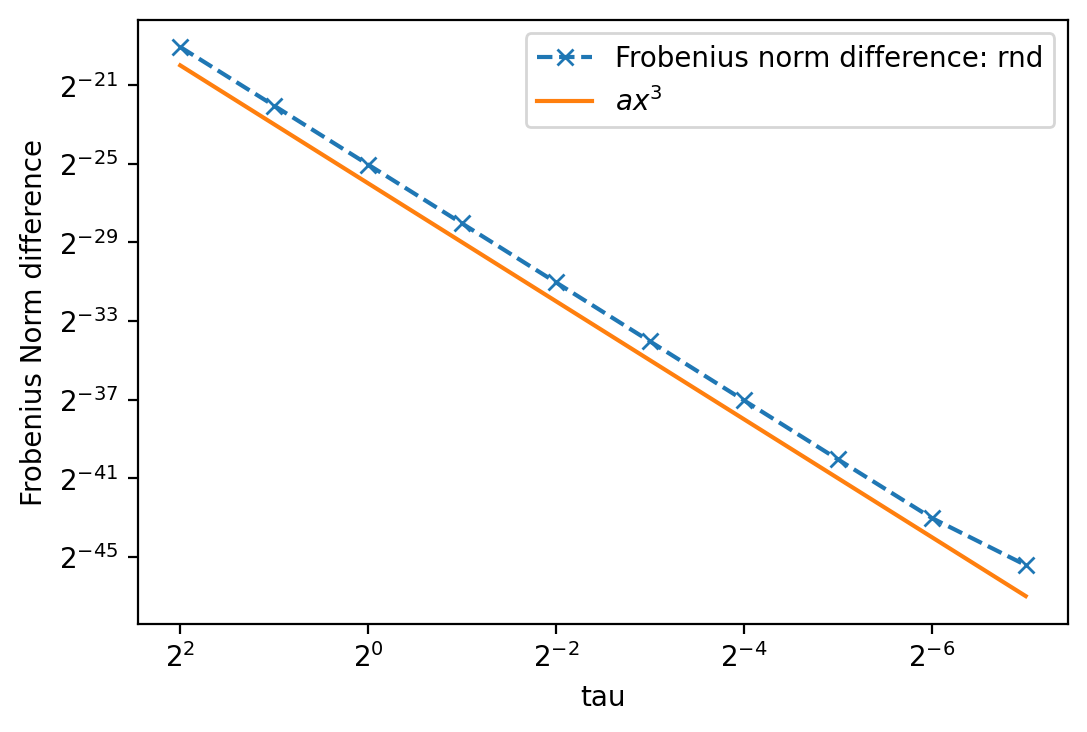

In [113]:
a = 1.5e-8
fig = plt.figure(dpi=200)
plt.loglog(taus[::], np.sort(error_fro + error_fro2)[::-1], '--x', base=2, label='Frobenius norm difference: rnd')
plt.plot(taus, a*taus**3, label=r'$a x^3$')
plt.gca().invert_xaxis()
plt.ylabel(r'Frobenius Norm difference')
plt.xlabel('tau')
plt.legend()

In [ ]:
from opentn.transformations import exp_operator_dt

taus = np.logspace(start=2, stop=-7, num=10, base=2)
exact_tau = []
for tau in taus:
    print(f'tau = {tau}')
    exp_tot = exp_operator_dt(Lvec, tau=tau, library='jax')
    exact_tau.append(exp_tot)

In [ ]:
approx_tau = []
for tau in taus:
    print(f'tau = {tau}')
    exp_odd = exp_operator_dt(Lvec_odd, tau=tau/2, library='jax')
    exp_even = exp_operator_dt(Lvec_even, tau=tau, library='jax')
    approx = exp_odd@exp_even@exp_odd
    approx_tau.append(approx)

In [ ]:
for i in range(len(taus)):
    
    print('cosine similarity: ', cosine_similarity(exact_tau[i], approx_tau[i]))
    

In [ ]:
# idea: use diamond norm from qutip. Transform matrices onto qutip objects.
# from forestbencharking: https://forest-benchmarking.readthedocs.io/en/latest/examples/distance_measures.html 
# we should be using it for choi matrices
from opentn.optimization import  diamond_norm_distance

# transform superoperators to choi
# choi_approx = super2choi(exp_approx)
# choi_exact = super2choi(exp_Lvec)

# dnorm = diamond_norm_distance(choi_approx, choi_exact)
# dnorm

In [ ]:
from opentn.transformations import super2choi, choi2super, kraus2choi, vectorize

Id = np.asarray([[1, 0], [0, 1]])
Xd = np.asarray([[0, 1], [1, 0]])

from scipy.linalg import expm

# Define unitary
theta = 0.4
Ud = expm(-theta*1j*Xd/2)

choi0 = kraus2choi([Id])
choi1 = kraus2choi([Ud])
choi2 = kraus2choi([Xd])

dnorm_test = diamond_norm_distance(choi0, choi1)
dnorm_test

# After meeting on 19th June:

In [ ]:
#  I should try first of all a double precision calculation with jax. Let's see what happens.

# Update:
changed to double precision and now the graph looks way better. It actually scales down when going to low timesteps. However, the problem is the total scale. Already for t=4 the scaling is "good" (small). See where the factor is coming from.

Try random matrices:

In [75]:
# construct random Lvec_odd + Lvec_even = Lvec
Lvec_odd_rnd = np.random.normal(size=(d**(2*N),d**(2*N))) / np.sqrt(d**(4*N))
Lvec_even_rnd = np.random.normal(size=(d**(2*N),d**(2*N))) / np.sqrt(d**(4*N))
Lvec_rnd = Lvec_even_rnd + Lvec_odd_rnd

In [154]:
# check commutator for random as well
commutator_rnd = Lvec_even_rnd@Lvec_odd_rnd - Lvec_odd_rnd@Lvec_even_rnd
print(np.allclose(commutator_rnd, np.zeros_like(Lvec_rnd)))
print(np.max(commutator_rnd))
print(np.min(commutator_rnd))
print(np.linalg.norm(Lvec_even_rnd))
print(np.linalg.norm(Lvec_odd_rnd))
print(np.linalg.norm(Lvec_rnd))
print(np.linalg.norm(commutator_rnd))

False
2.8083721203161507e-05
-2.8196486525773434e-05
1.0001390147571767
0.9997203705690085
1.413961199521624
0.02209110002085059


In [153]:
# this is the one for the real matrices.
print(np.linalg.norm(Lvec_even))
print(np.linalg.norm(Lvec_odd))
print(np.linalg.norm(Lvec))
print(np.linalg.norm(commutator))

0.1199999999999998
0.16248076809271875
0.2465765601187573
0.00015051993223490356


In [155]:
# TODO: relative norm for both normal and rnd
# let's compute the approximation of both the random and not random with tau = 4
tau = 4
# for the real one
exp_tot = exp_operator_dt(Lvec, tau=tau, library='jax')
exp_odd = exp_operator_dt(Lvec_odd, tau=tau/2, library='jax')
exp_even = exp_operator_dt(Lvec_even, tau=tau, library='jax')
approx = exp_odd @ exp_even @ exp_odd
# and for the random one
exp_tot_rnd = exp_operator_dt(Lvec_rnd, tau=tau, library='jax')
exp_odd_rnd = exp_operator_dt(Lvec_odd_rnd, tau=tau/2, library='jax')
exp_even_rnd = exp_operator_dt(Lvec_even_rnd, tau=tau, library='jax')
approx_rnd = exp_odd_rnd @ exp_even_rnd @ exp_odd_rnd

In [164]:
print('normal')
for op in [exp_tot, exp_odd, exp_even]:
    print(np.linalg.norm(op))

print('rnd')
for op in [exp_tot_rnd, exp_odd_rnd, exp_even_rnd]:
    print(np.linalg.norm(op))

normal
63.20911532301765
63.761046447689225
63.68238672644092
rnd
64.25070889205718
64.03109890056759
64.12597097619738


In [169]:
# now compute the norm difference for both cases
norm_diff = frobenius_norm(exp_tot, approx)
print('norm difference: ', norm_diff)
norm_diff_rnd = frobenius_norm(exp_tot_rnd, approx_rnd)
print('norm difference: ', norm_diff_rnd)
# what are the ratios wrt to the total norm of the individual terms tho?
ratio = norm_diff/(np.linalg.norm(Lvec_even) + np.linalg.norm(Lvec_odd))
ratio_rnd = norm_diff_rnd/(np.linalg.norm(Lvec_even_rnd) + np.linalg.norm(Lvec_odd_rnd))
print('ratio: ', ratio)
print('ratio rnd: ', ratio_rnd)
1/(0.1199999999999998 + 0.16248076809271875)


norm difference:  1.8351809852605092e-06
norm difference:  0.0035658268220446166
ratio:  6.496658153584985e-06
ratio rnd:  0.0017830387717299512


3.540064007726609

In [221]:
100*300/51000

0.5882352941176471

In [177]:
# NOTE: when dividing by 6, norm of even is: 0.16668983579286278 (similar for odd)
# reduce the operators by a factor of 6
exp_tot_rnd_red = exp_operator_dt(Lvec_rnd/6, tau=tau, library='jax')
exp_odd_rnd_red = exp_operator_dt(Lvec_odd_rnd/6, tau=tau/2, library='jax')
exp_even_rnd_red = exp_operator_dt(Lvec_even_rnd/6, tau=tau, library='jax')
approx_rnd_red = exp_odd_rnd_red @ exp_even_rnd_red @ exp_odd_rnd_red
# norm difference
norm_diff_rnd_red = frobenius_norm(exp_tot_rnd_red, approx_rnd_red)
print('norm difference: ', norm_diff_rnd_red)

norm difference:  1.6495088157430632e-05


In [178]:
# calculating the norm for the odd and even liouvillian
eigvals_tot= np.linalg.eigvals(Lvec)
eigvals_odd= np.linalg.eigvals(Lvec_odd)
eigvals_even= np.linalg.eigvals(Lvec_even)

In [208]:
np.max(np.abs(eigvals_even))

0.005000000000000034

In [186]:
np.min(np.abs(eigvals_tot))

0.0

In [190]:
len([eig for eig in np.abs(eigvals_tot) if eig >=tol])

4047

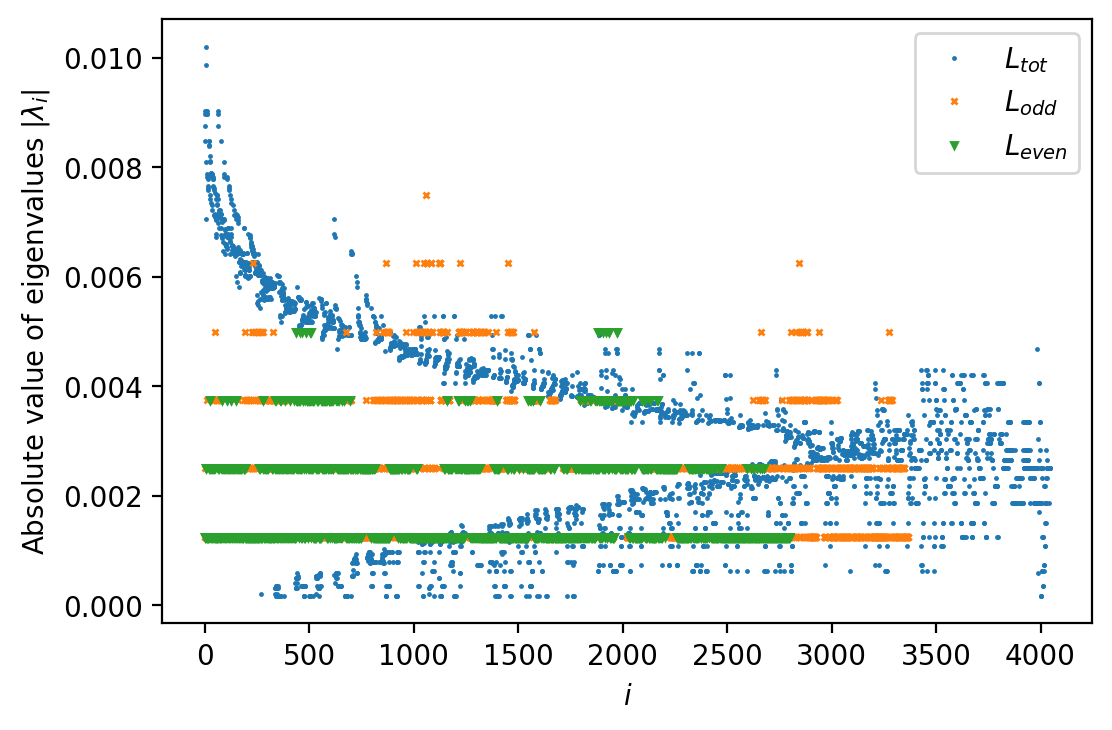

In [219]:
tol = 1e-5
plt.figure(dpi=200)
plt.plot([eig for eig in np.abs(eigvals_tot) if eig >=tol], 'o', markersize=0.75, label=r'$L_{tot}$')
plt.plot([eig for eig in np.abs(eigvals_odd) if eig >=tol], 'x', markersize=2.5,label=r'$L_{odd}$')
plt.plot([eig for eig in np.abs(eigvals_even) if eig >=tol], 'v', markersize=2.5,label=r'$L_{even}$')
plt.ylabel(r'Absolute value of eigenvalues |$\lambda_i$|')
plt.xlabel(r'$i$')
plt.legend()

In [76]:
error_fro_rnd = []
for tau in taus[:5]:
    print(f'tau = {tau}')
    exp_tot = exp_operator_dt(Lvec_rnd, tau=tau, library='jax')
    exp_odd = exp_operator_dt(Lvec_odd_rnd, tau=tau/2, library='jax')
    exp_even = exp_operator_dt(Lvec_even_rnd, tau=tau, library='jax')
    approx = exp_odd @ exp_even @ exp_odd
    fro_error =  frobenius_norm(exp_tot, approx)
    print('frobenius norm: ', fro_error)
    error_fro_rnd.append(fro_error)

tau = 4.0
frobenius norm:  0.0035658268220446166
tau = 2.0
frobenius norm:  0.00044545124652340686
tau = 1.0
frobenius norm:  5.567259813992959e-05
tau = 0.5
frobenius norm:  6.9587901247289e-06
tau = 0.25
frobenius norm:  8.698392816643911e-07


In [99]:
popt, pcov = curve_fit(func, np.log2(taus[:5]), np.log2(error_fro_rnd))
popt

array([  3.00026875, -14.13242908])

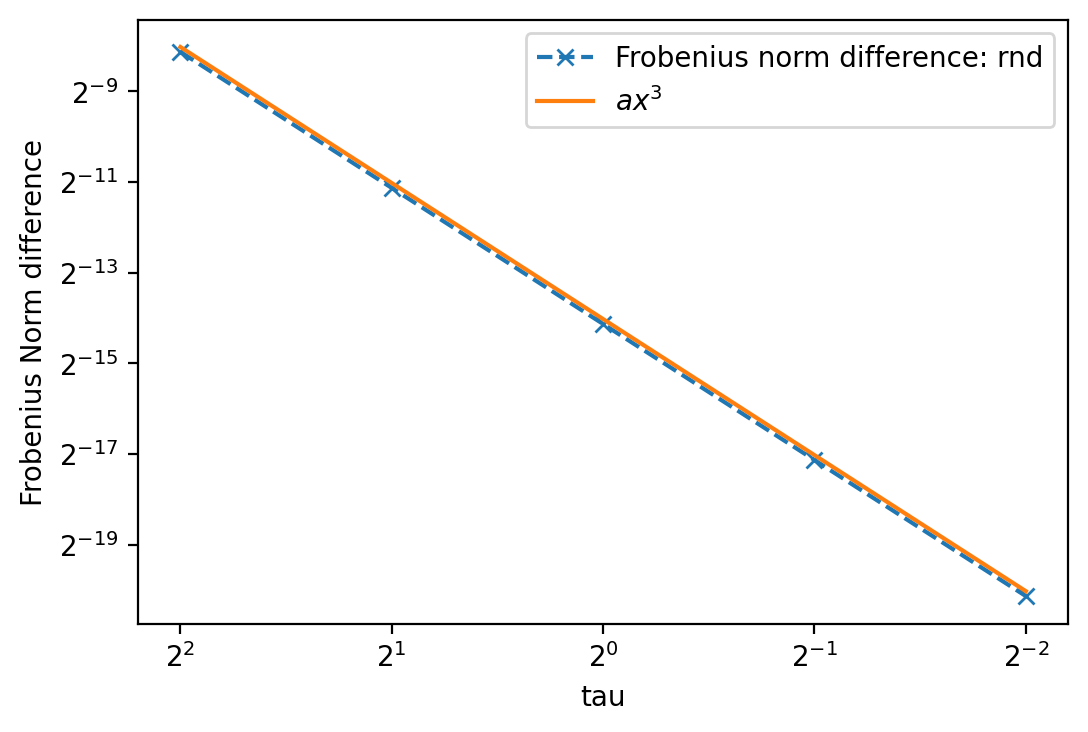

In [107]:
a = 0.6e-4
fig = plt.figure(dpi=200)
plt.loglog(taus[:5], error_fro_rnd, '--x', base=2, label='Frobenius norm difference: rnd')
plt.plot(taus[:5], a*taus[:5]**3, label=r'$a x^3$')
plt.gca().invert_xaxis()
plt.ylabel(r'Frobenius Norm difference')
plt.xlabel('tau')
plt.legend()

In [134]:
# let me do 5 random matrices repetition and calculate the error per realization per tau
def get_rnd_error(reps:int=5, taus:list=None, max_taus=5, loss_fn=frobenius_norm):
    if not taus:
        taus = np.logspace(start=max_taus//2, stop=-(max_taus//2), num=max_taus, base=2)

    error_matrix = np.empty(shape=(reps, max_taus))

    for r in range(reps):
        print(f'rep = {r}')
        Lvec_odd_rnd = np.random.normal(size=(d**(2*N),d**(2*N))) / np.sqrt(d**(4*N))
        Lvec_even_rnd = np.random.normal(size=(d**(2*N),d**(2*N))) / np.sqrt(d**(4*N))
        Lvec_rnd = Lvec_even_rnd + Lvec_odd_rnd

        for t, tau in enumerate(taus):
            print(f'tau = {tau}')
            exp_tot = exp_operator_dt(Lvec_rnd, tau=tau, library='jax')
            exp_odd = exp_operator_dt(Lvec_odd_rnd, tau=tau/2, library='jax')
            exp_even = exp_operator_dt(Lvec_even_rnd, tau=tau, library='jax')
            approx = exp_odd @ exp_even @ exp_odd
            error =  loss_fn(exp_tot, approx)
            print('error: ', error)
            error_matrix[r,t] = (error)

    return error_matrix

In [135]:
error_matrix = get_rnd_error(reps=5)

rep = 0
tau = 4.0
error:  0.003568082399144354
tau = 2.0
error:  0.00044573924058725526
tau = 1.0
error:  5.5708975249910196e-05
tau = 0.5
error:  6.963360889608923e-06
tau = 0.25
error:  8.704121044141082e-07
rep = 1
tau = 4.0
error:  0.0035694656313824216
tau = 2.0
error:  0.0004459121967206489
tau = 1.0
error:  5.573058803834358e-05
tau = 0.5
error:  6.9660617519833264e-06
tau = 0.25
error:  8.707496562404431e-07
rep = 2
tau = 4.0
error:  0.003564441708620497
tau = 2.0
error:  0.00044528697976762855
tau = 1.0
error:  5.5652612628625525e-05
tau = 0.5
error:  6.956325979887737e-06
tau = 0.25
error:  8.69533385346189e-07
rep = 3
tau = 4.0
error:  0.0035680729835967763
tau = 2.0
error:  0.0004457400434486545
tau = 1.0
error:  5.5709191957661326e-05
tau = 0.5
error:  6.963395013898031e-06
tau = 0.25
error:  8.704168022202862e-07
rep = 4
tau = 4.0
error:  0.003568737467709079
tau = 2.0
error:  0.00044581868550908684
tau = 1.0
error:  5.5718772778051515e-05
tau = 0.5
error:  6.964577853438

[3.56776004e-03 4.45699429e-04 5.57040281e-05 6.96274430e-06
 8.70335142e-07]
[  3.00025911 -14.13162079]


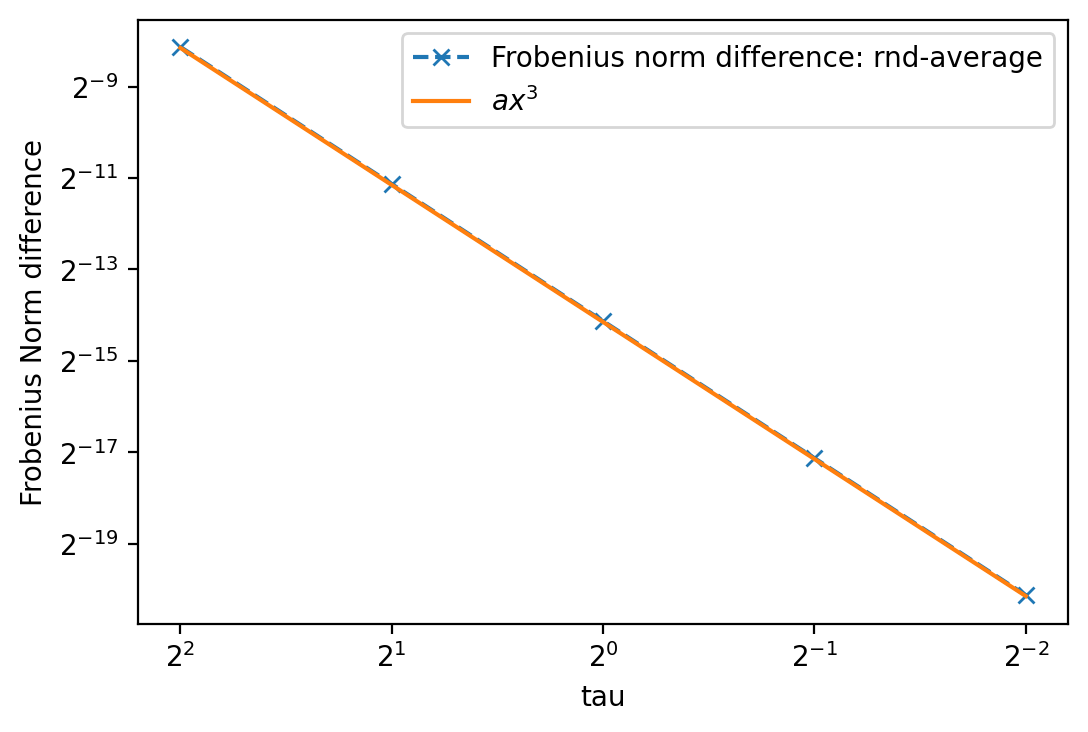

In [218]:
error_mean_tau = np.mean(error_matrix, axis=0)
print(error_mean_tau)

max_taus = 5
taus = np.logspace(start=max_taus//2, stop=-(max_taus//2), num=max_taus, base=2)

popt, pcov = curve_fit(func, np.log2(taus), np.log2(error_mean_tau))
print(popt)

fig = plt.figure(dpi=200)
plt.loglog(taus, error_mean_tau, '--x', base=2, label='Frobenius norm difference: rnd-average')
plt.gca().invert_xaxis()
plt.plot(taus, 0.55e-4*taus**3, label=r'$a x^3$')
plt.ylabel(r'Frobenius Norm difference')
plt.xlabel('tau')
plt.legend()

In [216]:
error_mean_tau

array([3.56776004e-03, 4.45699429e-04, 5.57040281e-05, 6.96274430e-06,
       8.70335142e-07])

# Monday 26th:
After seeing that the norm difference makes sense for operators with norm of around 0.1, then maybe I can try the optimization again and see if this time it actually works?

In [249]:
from opentn.optimization import gds, compute_loss, frobenius_norm, update, calculate_norms
from opentn.transformations import factorize_psd, choi2super, super2choi

In [238]:
# get again the X1 and X2 from Lvec_odd and Lvec_even, respectively (the liovillians exp actually)
X1 = factorize_psd(psd=super2choi(exp_odd))
X2 = factorize_psd(psd=super2choi(exp_even))

In [241]:
# let me check if converting X1 back actually gives what we need
approx_1 = X1@X1.conj().T

In [242]:
jnp.allclose(approx_1, super2choi(exp_odd))

DeviceArray(True, dtype=bool)

In [243]:
cost_list_fro, grads_list_fro, xi_fro = gds(fn=compute_loss, x0=[X1, X2, X1], iter=2, loss_fn=frobenius_norm, rate=1e-2, exact= exp_tot)

Starting iteration: 0
* Cost function: 1.8351809853518556e-06
Starting iteration: 1
* Cost function: 2.013013119501657


In [251]:
calculate_norms([X1, X2, X1])

7.9999999999999964
7.999999999999998
7.9999999999999964


In [250]:
calculate_norms(grads_list_fro[0])

5.98069086135149
6.020445869114712
6.031741280884185


In [253]:
for op in [X1, X2, X1]:
    print(jnp.max(op))

for op in grads_list_fro[0]:
    print(jnp.max(op))

(1.0000000000000002+0j)
(0.9999999999999998+0j)
(1.0000000000000002+0j)
(0.8770549958628684+0j)
(0.8867571028148751+0j)
(0.889850817787306+0j)


In [272]:
Xi_new = update([X1, X2, X1], grads=grads_list_fro[0], rate=1e-8)
compute_loss(*Xi_new, loss_fn=frobenius_norm, exact=exp_tot) 
#np: 59.1 s, cost: 0.20141918
#jnp: 1m 15s 20141918
#np: rate = 1e-4, 0.02014299
# rate = 1e-7, 1.92190425e-05

DeviceArray(1.85667507e-06, dtype=float64)

In [274]:
compute_loss(*update([X1, X2, X1], grads=grads_list_fro[0], rate=1e-9), loss_fn=frobenius_norm, exact=exp_tot) 

DeviceArray(1.73511221e-06, dtype=float64)

In [276]:
# lets do an optimization step with this new parameters
cost_list_fro2, grads_list_fro2, xi_fro2 = gds(fn=compute_loss, x0=update([X1, X2, X1], grads=grads_list_fro[0], rate=1e-9), iter=3, loss_fn=frobenius_norm, rate=1e-9, exact= exp_tot)

Starting iteration: 0
* Cost function: 1.7351122076692266e-06
Starting iteration: 1
* Cost function: 1.665139703537312e-06
Starting iteration: 2
* Cost function: 1.6188998840934994e-06


In [280]:
cost_list_fro3, grads_list_fro3, xi_fro3 = gds(fn=compute_loss, x0=xi_fro2[-1], iter=3, loss_fn=frobenius_norm, rate=1e-9, exact= exp_tot)

Starting iteration: 0
* Cost function: 1.5896880290027847e-06
Starting iteration: 1
* Cost function: 1.5718060328926457e-06
Starting iteration: 2
* Cost function: 1.561063153296394e-06


In [281]:
cost_list_fro4, grads_list_fro4, xi_fro4 = gds(fn=compute_loss, x0=xi_fro3[-1], iter=3, loss_fn=frobenius_norm, rate=1e-9, exact= exp_tot)

Starting iteration: 0
* Cost function: 1.5546582004547543e-06
Starting iteration: 1
* Cost function: 1.5508292726019994e-06
Starting iteration: 2
* Cost function: 1.5485088368040208e-06


In [287]:
cost_list_fro5, grads_list_fro5, xi_fro5 = gds(fn=compute_loss, x0=xi_fro4[-1], iter=3, loss_fn=frobenius_norm, rate=1e-9, exact= exp_tot)

Starting iteration: 0
* Cost function: 1.5470644247033028e-06
Starting iteration: 1
* Cost function: 1.5461262577555021e-06
Starting iteration: 2
* Cost function: 1.545479813268905e-06


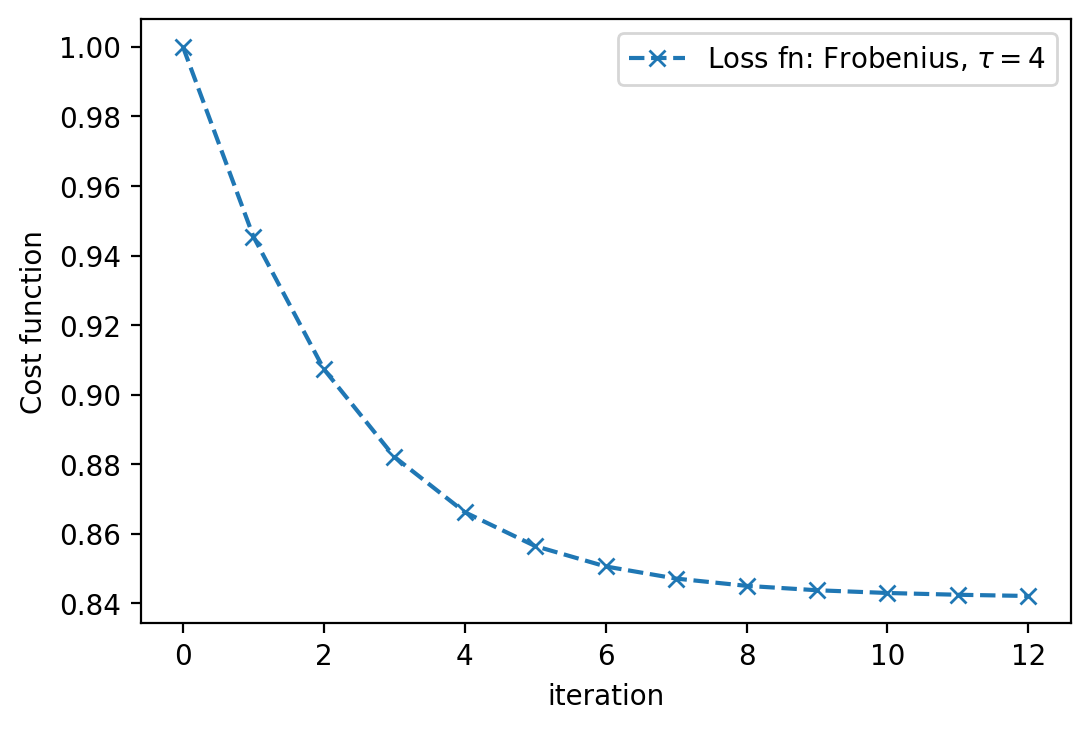

In [307]:
data = cost_list_fro[0:1] + cost_list_fro2 + cost_list_fro3 + cost_list_fro4 + cost_list_fro5
fig = plt.figure(dpi=200)
plt.plot(range(len(data)), np.array(data)/data[0], '--x', label=r'Loss fn: Frobenius, $\tau = 4$')
plt.ylabel(r'Cost function')
plt.xlabel('iteration')
plt.legend()

In [291]:
# now lets do the same but for tau = 0.5
tau = 0.5

exp_tot_05 = exp_operator_dt(Lvec, tau=tau, library='jax')
exp_odd_05 = exp_operator_dt(Lvec_odd, tau=tau/2, library='jax')
exp_even_05 = exp_operator_dt(Lvec_even, tau=tau, library='jax')

X1_05 = factorize_psd(psd=super2choi(exp_odd_05))
X2_05 = factorize_psd(psd=super2choi(exp_even_05))

In [294]:
cost_list_fro_05, grads_list_fro_05, xi_fro_05 = gds(fn=compute_loss, x0=[X1_05, X2_05, X1_05], iter=1, loss_fn=frobenius_norm, rate=1e-9, exact= exp_tot_05)

Starting iteration: 0
* Cost function: 3.672076939174579e-09


In [296]:
cost_list_fro_05_2, grads_list_fro_05_2, xi_fro_05_2 = gds(fn=compute_loss, x0=update([X1_05, X2_05, X1_05], grads=grads_list_fro_05[0], rate=1e-12), iter=8, loss_fn=frobenius_norm, rate=1e-12, exact= exp_tot_05)

Starting iteration: 0
* Cost function: 3.567650716849533e-09
Starting iteration: 1
* Cost function: 3.479188688627163e-09
Starting iteration: 2
* Cost function: 3.4052989337264625e-09
Starting iteration: 3
* Cost function: 3.344383347572413e-09
Starting iteration: 4
* Cost function: 3.294755824658927e-09
Starting iteration: 5
* Cost function: 3.25474426295821e-09
Starting iteration: 6
* Cost function: 3.222773254709786e-09
Starting iteration: 7
* Cost function: 3.1974193261204456e-09


In [298]:
cost_list_fro_05_3, grads_list_fro_05_3, xi_fro_05_3 = gds(fn=compute_loss, x0=xi_fro_05_2[-1], iter=4, loss_fn=frobenius_norm, rate=1e-12, exact= exp_tot_05)

Starting iteration: 0
* Cost function: 3.1774372304216826e-09
Starting iteration: 1
* Cost function: 3.1617688363584033e-09
Starting iteration: 2
* Cost function: 3.1495315666119767e-09
Starting iteration: 3
* Cost function: 3.140004542750324e-09


In [300]:
cost_list_fro_05_4, grads_list_fro_05_4, xi_fro_05_4 = gds(fn=compute_loss, x0=xi_fro_05_3[-1], iter=4, loss_fn=frobenius_norm, rate=1e-12, exact= exp_tot_05)

Starting iteration: 0
* Cost function: 3.1326048798397006e-09
Starting iteration: 1
* Cost function: 3.12686805803476e-09
Starting iteration: 2
* Cost function: 3.1224259219657186e-09
Starting iteration: 3
* Cost function: 3.118989141822764e-09


In [302]:
cost_list_fro_05_5, grads_list_fro_05_5, xi_fro_05_5 = gds(fn=compute_loss, x0=xi_fro_05_4[-1], iter=4, loss_fn=frobenius_norm, rate=1e-12, exact= exp_tot_05)

Starting iteration: 0
* Cost function: 3.1163308891136795e-09
Starting iteration: 1
* Cost function: 3.1142749627808394e-09
Starting iteration: 2
* Cost function: 3.112683810056345e-09
Starting iteration: 3
* Cost function: 3.11145155418053e-09


In [322]:
calculate_norms(grads_list_fro_05[-1])
print('--')
calculate_norms(grads_list_fro_05_5[-1])

6.012915572544449
6.01785773996208
6.0193176320813695
--
0.5770557092214873
0.585376719462305
0.5834048912158369


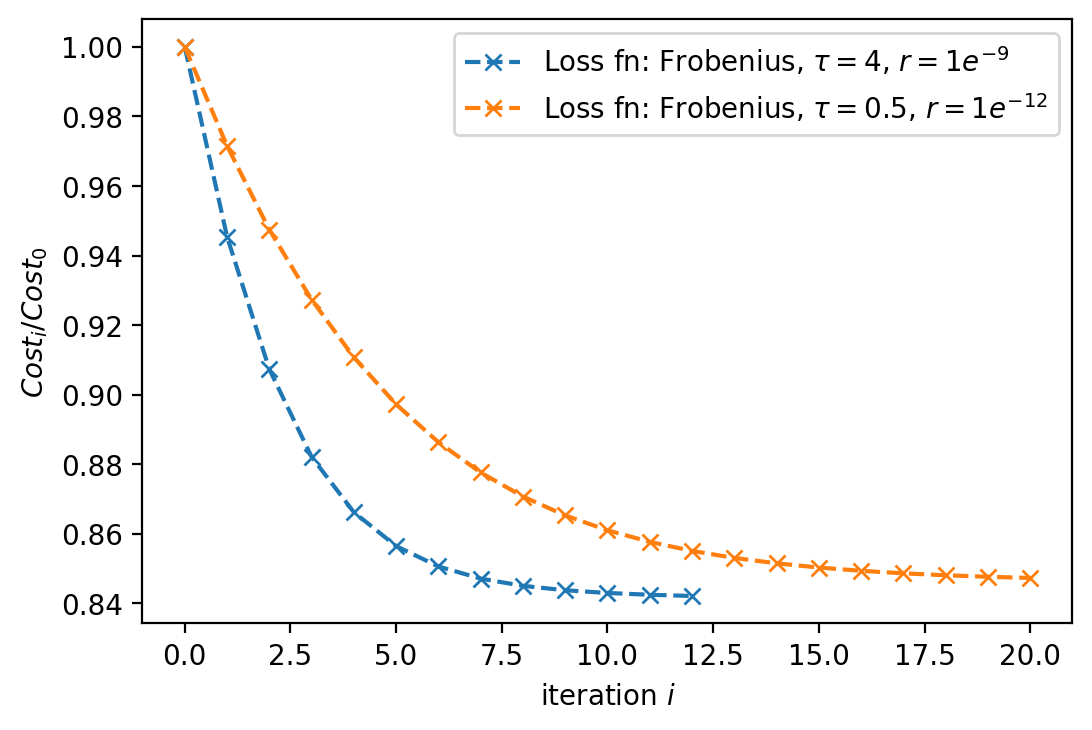

In [314]:
data = cost_list_fro_05 + cost_list_fro_05_2 + cost_list_fro_05_3 + cost_list_fro_05_4 + cost_list_fro_05_5
data2 = cost_list_fro[0:1] + cost_list_fro2 + cost_list_fro3 + cost_list_fro4 + cost_list_fro5

fig = plt.figure(dpi=200)
plt.plot(range(len(data2)), np.array(data2)/data2[0], '--x', label=r'Loss fn: Frobenius, $\tau = 4$, $r=1e^{-9}$')
plt.plot(range(len(data)), np.array(data)/data[0], '--x', label=r'Loss fn: Frobenius, $\tau = 0.5$, $r=1e^{-12}$')
plt.ylabel(r'$Cost_i/Cost_{0}$')
plt.xlabel('iteration $i$')
plt.legend()

In [319]:
np.array(data)/data[0]

DeviceArray([1.        , 0.97156208, 0.94747162, 0.92734956, 0.9107607 ,
             0.89724586, 0.88634969, 0.87764317, 0.87073865, 0.86529702,
             0.86103012, 0.8576976 , 0.85510315, 0.85308803, 0.85152575,
             0.85031604, 0.84938012, 0.84865621, 0.84809633, 0.84766302,
             0.84732744], dtype=float64)

In [256]:
# small detour because I want to see what of the three methods for multiplication is faster
%timeit jnp.dot(X1, X1.conj().T).block_until_ready()

14.2 s ± 1.45 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [257]:
%timeit jnp.matmul(X1, X1.conj().T).block_until_ready()

15.4 s ± 1.12 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [260]:
%timeit X1@X1.conj().T

9.37 s ± 767 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [264]:
from jax import device_put
X1_device = device_put(X1)

In [265]:
%timeit X1_device@X1_device.conj().T

16 s ± 1.02 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [394]:
# now optimize the individual tensors inside the Y.
# remember what we learned about leg reordering
from opentn.transformations import vectorize
test_array = np.array(list(range(6))).reshape((2,3))
print(test_array)
vectorize(test_array).reshape(2,3)

[[0 1 2]
 [3 4 5]]


array([[0, 1, 2],
       [3, 4, 5]])

In [397]:
vectorize(test_array).T.reshape(3,2)

array([[0, 1],
       [2, 3],
       [4, 5]])

In [390]:
test_array.T

array([[0, 3],
       [1, 4],
       [2, 5]])

In [402]:
# convert matrix onto row vector directly!
test_array.reshape(1,-1).reshape((3,2))

array([[0, 1],
       [2, 3],
       [4, 5]])

In [403]:
np.allclose(vectorize(test_array).T, vectorize(test_array.T))

False

In [423]:
xi_fro5[-1][0].dtype

dtype('complex128')

In [425]:
jnp.finfo(jnp.complex128)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

In [453]:
from jax.experimental import sparse

# sparse.sparsify(jnp.linalg.norm)(sparse.BCOO.fromdense(xi_fro5[-1][0]))

In [454]:
# are the matrix sparse?
# print(scipy.sparse.csr_matrix(xi_fro5[-1][0]))

In [419]:
np.log2(np.sqrt(16208))

6.9922092294005695

In [416]:
16208/(4096*4096)

0.0009660720825195312

In [408]:
calculate_norms(xi_fro5[-1])

7.999999999947055
7.999999999947055
7.999999999947055


In [412]:
jnp.allclose(xi_fro5[-1][0], xi_fro5[-1][1])

DeviceArray(False, dtype=bool)

In [445]:
def test(a,b,c,d):
    print(a,b,c,d)

def test2(a, **kwargs):
    test(a,**kwargs)
    

In [446]:
test2(1,b=2,c=3,d=4)

1 2 3 4


In [450]:
a = np.array([1,2,3])
a[[2,1,0]]

array([3, 2, 1])

In [488]:
from opentn.optimization import model_Zs, model_Ys
from opentn.transformations import lindbladian2super, get_indices_supertensored2liouvillianfull, create_supertensored_from_local
superop = lindbladian2super(Li=[Lnn])
superop = exp_operator_dt(superop, tau=4, library='jax')
W1 = factorize_psd(super2choi(superop))

In [486]:
compute_loss(xi=W1, loss_fn=frobenius_norm, model=model_Zs, exact=exp_tot, Xj=xi_fro5[1], Xk=xi_fro5[2])

(65536, 65536)
0


AssertionError: 65536 != 0

In [473]:
W1.shape

(16, 16)

In [489]:
test = create_supertensored_from_local(localop=W1, N=6)
test.shape

: 

: 

In [7]:
# might be a good moment to do everything with functions and to change for 4 sites.
from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, factorize_psd, super2choi
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=4, d=2, gamma=1e-2)
tau = 4
superops_exp = []
for i, op in enumerate([Lvec, Lvec_odd, Lvec_even, Lnn]):
    if i == 1 or i == 3:
        superops_exp.append(exp_operator_dt(op, tau/2, 'jax'))
    else:
        superops_exp.append(exp_operator_dt(op, tau, 'jax'))
exp_Lvec, exp_Lvec_odd, exp_Lvec_even, exp_Lnn = superops_exp

X1 = factorize_psd(psd=super2choi(exp_Lvec_odd))
X2 = factorize_psd(psd=super2choi(exp_Lvec_even))

In [142]:
from opentn.optimization import gds, frobenius_norm, model_Ys, compute_loss
cost_n4, grads_n4, xi_n4 = gds(fn=compute_loss, x0=[X1, X2, X1], iter=4000, loss_fn=frobenius_norm, model=model_Ys, rate=1.5e-9, exact = exp_Lvec, show_cost=False, store_all=False)

0.558693340042288


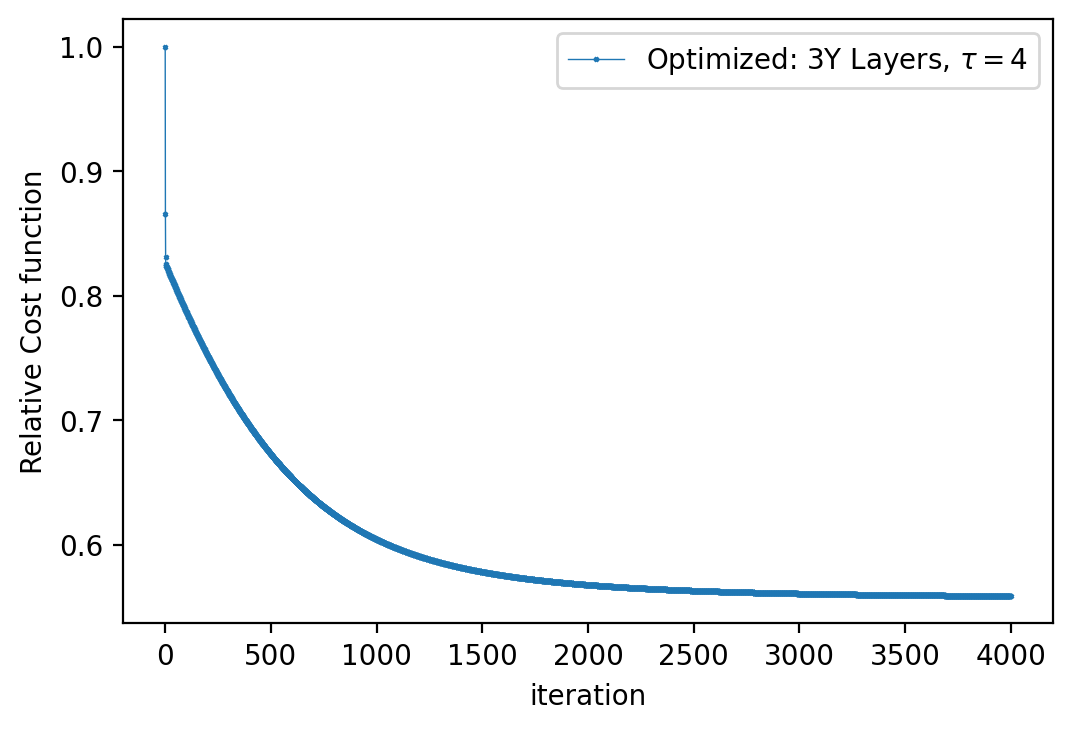

In [180]:
data = cost_n4[::]
print(data[-1]/data[0])
fig = plt.figure(dpi=200)
plt.plot(range(len(data)), np.array(data)/cost_n4[0], '-x', markersize=1.5,linewidth=0.5,label=r'Optimized: 3Y Layers, $\tau = 4$')
plt.ylabel(r'Relative Cost function')
plt.xlabel('iteration')
plt.legend()


In [151]:
from opentn.optimization import model_Zs
from opentn.transformations import lindbladian2super, create_supertensored_from_local
superop = lindbladian2super(Li=[Lnn])
superop = exp_operator_dt(superop, tau/2, 'jax')
W1 = factorize_psd(super2choi(superop)) 

In [152]:
compute_loss(xi=W1, loss_fn=frobenius_norm, model=model_Zs, exact=exp_Lvec, Xj=xi_n4[-1][1], Xk=xi_n4[-1][2], N=4)

DeviceArray(1.91967093e-07, dtype=float64)

In [148]:
cost_n4[-1]

DeviceArray(1.47400104e-07, dtype=float64)

In [172]:
# lets do an optimization 
cost_w, grads_w, xi_w = gds(fn=compute_loss, x0=W1, iter=4000, loss_fn=frobenius_norm, model=model_Zs, rate=2e-10, exact = exp_Lvec, Xj=xi_n4[-1][1], Xk=xi_n4[-1][2], N=4, show_cost=False, store_all=False)
cost_w[-1]

DeviceArray(1.79608592e-07, dtype=float64)

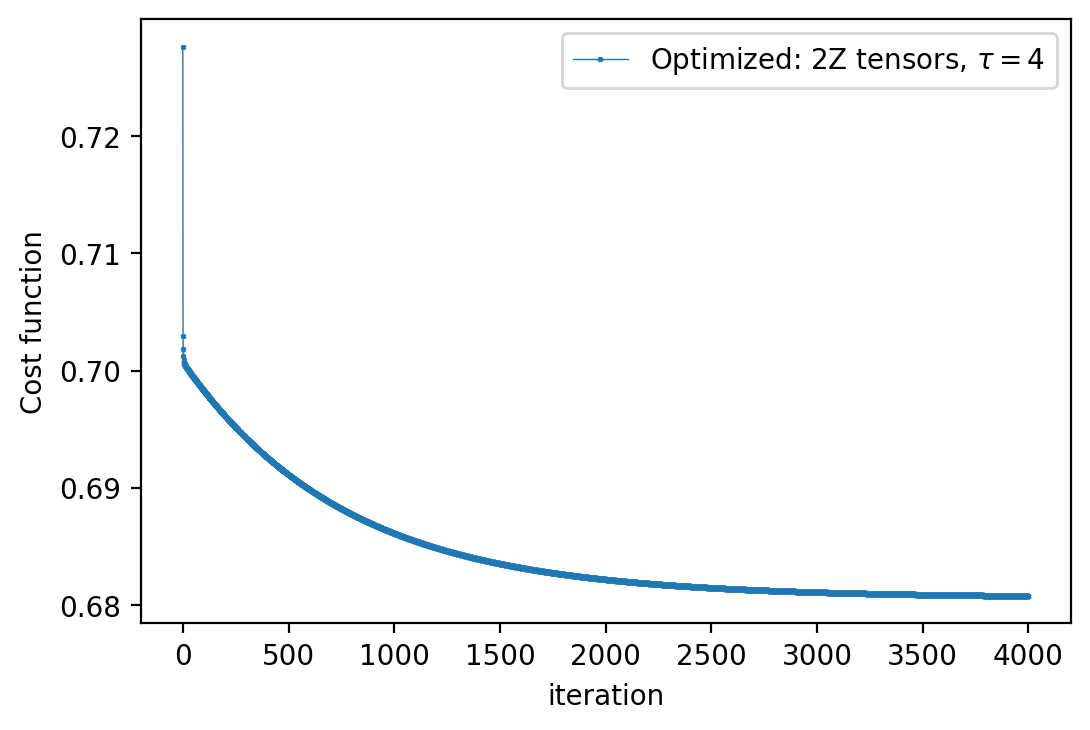

In [181]:
data = cost_n4[::]
fig = plt.figure(dpi=200)
# plt.plot(range(len(data)), np.array(data)/cost_n4[0], '-x', markersize=1.5,linewidth=0.5,label=r'Optimized: 3Y Layers, $\tau = 4$')
data = cost_w[::]
plt.plot(range(len(data)), np.array(data)/cost_n4[0], '-x', markersize=1.5,linewidth=0.5,label=r'Optimized: 2Z tensors, $\tau = 4$')
plt.ylabel(r'Cost function')
plt.xlabel('iteration')
plt.legend()

In [174]:
cost_w[-1]/cost_n4[0] # for 2000 iterations: 0.68218619

DeviceArray(0.68077377, dtype=float64)

In [192]:
# now i should use the Y1 that we get from W1 and update in the same way Y2.
# lets check first if we get the same result when updating Z1 to Y1
from opentn.transformations import convert_supertensored2liouvillianfull
W1_local = xi_w[-1]
W1 = create_supertensored_from_local(W1_local, N=4)
X1_w = convert_supertensored2liouvillianfull(W1, N=4, d=2)

print('last evaluation: ',  cost_w[-1])

compute_loss(xi=[X1_w, xi_n4[-1][1], xi_n4[-1][2]], loss_fn=frobenius_norm, model=model_Ys, exact=exp_Lvec)

last evaluation:  1.7960859172182258e-07


DeviceArray(1.79608546e-07, dtype=float64)